Serie = trend + seasonality + cycles + noise

<AxesSubplot:>

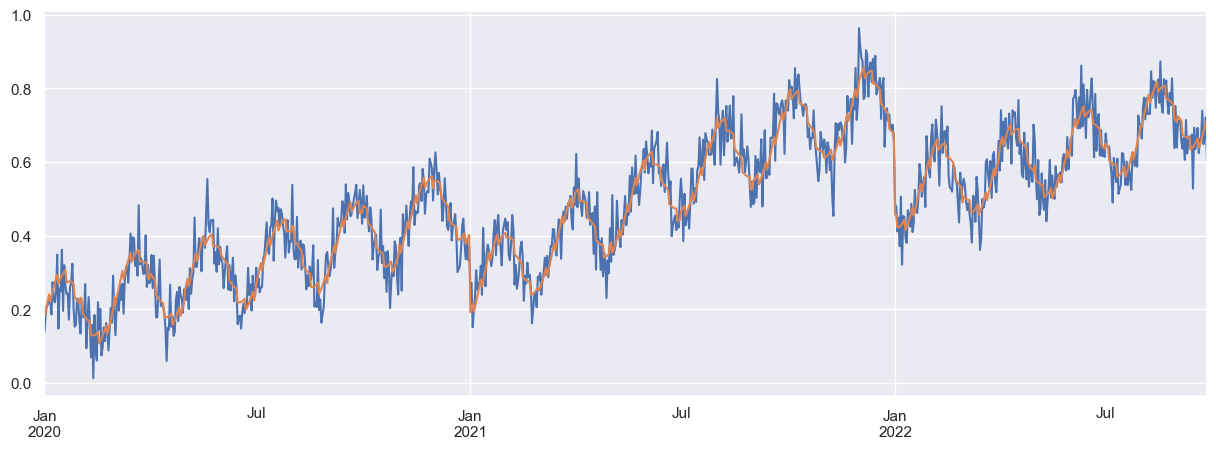

In [184]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Importing graph params from seaborn
sns.set_theme()

line = np.linspace(0, 100, 1000)
line_long = np.linspace(0, 10, 1000)

time_index = pd.date_range('1/1/2020', periods=1000)

serie = pd.Series(line, index=time_index)
trend_coefs = [0.005, 0.1]
trend = trend_coefs[0] * line + trend_coefs[1]
noise = np.random.normal(0, .05, 1000)
cycle = np.sin(line) * 0.1 + np.cos(line_long) * 0.05
seasonal_effect = time_index.dayofweek * 0.005 + time_index.month * 0.02

value = trend + noise + cycle + seasonal_effect
value_without_noise = trend + cycle + seasonal_effect
value_without_trend = value - trend

series_to_be_predicted = pd.Series(value, index=time_index, name='real_value')
series_to_be_predicted_without_noise = pd.Series(value_without_noise, index=time_index, name='prediction_param_value')
series_to_be_predicted_without_trend = pd.Series(value_without_trend, index=time_index, name='prediction_param_value')

series_to_be_predicted.plot(figsize=(15, 5))
series_to_be_predicted_without_noise.plot(figsize=(15, 5))

In [156]:
from sklearn.metrics import mean_squared_error
print('MSE: ', mean_squared_error(series_to_be_predicted, series_to_be_predicted_without_noise))

MSE:  0.0025665233379625106


In [181]:
# Testing for stationarity
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(series_to_be_predicted_without_noise, regression='ct')
print('t-statistic = ', dftest[0])
print('p-value = ', f'{round(dftest[1]*100, 3)}%')
print('Critical values:')
for key, value in dftest[4].items():
    print('\t%s: %.3f' % (key, value))

Results of Dickey-Fuller Test:
t-statistic =  -4.79306310017172
p-value =  0.048%
Critical values:
	1%: -3.968
	5%: -3.415
	10%: -3.130


[0.00051298] 0.2283030807694561 [0.005, 0.1]


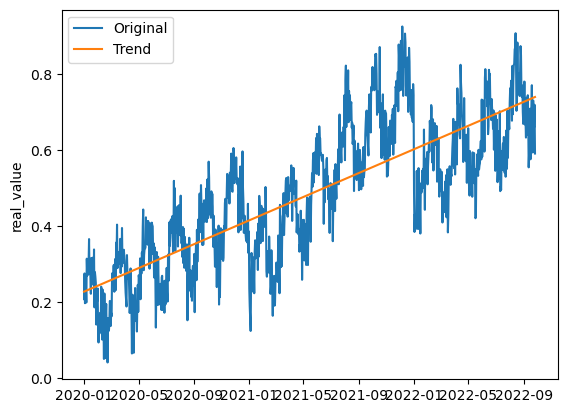

In [157]:
# Extracting components of the time series
from sklearn.linear_model import LinearRegression

model = LinearRegression()
trend_line = pd.Series(np.arange(0, 1000), index=time_index, name='trend_line')
X = pd.DataFrame(trend_line)

model.fit(X, series_to_be_predicted)
predicted_trend = model.predict(X)

predicted_trend_series = pd.Series(predicted_trend, index=time_index)
print(model.coef_, model.intercept_, trend_coefs)

sns.lineplot(data=series_to_be_predicted, label='Original')
sns.lineplot(data=predicted_trend_series, label='Trend');

<AxesSubplot:>

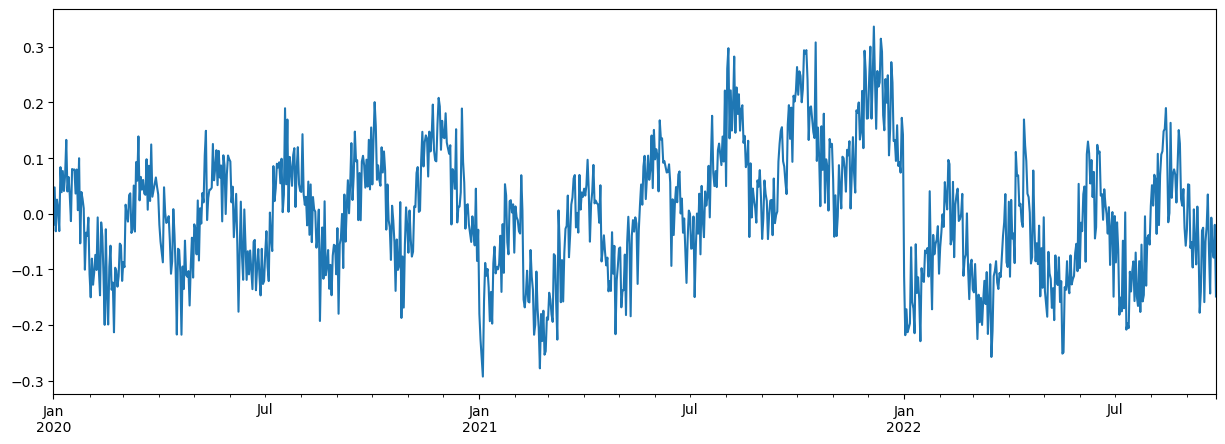

In [158]:
detrended_series = series_to_be_predicted - predicted_trend_series
detrended_series.plot(figsize=(15, 5))

<AxesSubplot:>

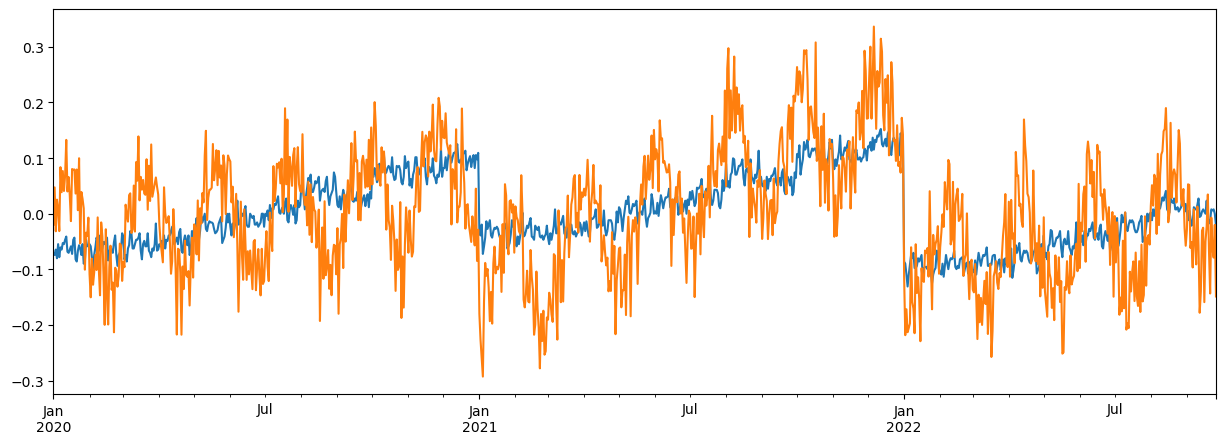

In [159]:
# Extracting the seasonal component

time_index_df = pd.DataFrame()
time_index_df['month'] = time_index.month
time_index_df['day'] = time_index.day
time_index_df['dayofweek'] = time_index.dayofweek
time_index_df['quarter'] = time_index.quarter
time_index_df['semester'] = time_index_df['quarter'].apply(lambda x: 1 if x <= 2 else 2)
time_index_df['year'] = time_index.year

time_index_df = pd.get_dummies(time_index_df, columns=['month', 'day', 'dayofweek', 'quarter', 'semester', 'year'])

model = LinearRegression()
X = time_index_df
model.fit(X, detrended_series)

predicted_seasonal = model.predict(X)
predicted_seasonal_series = pd.Series(predicted_seasonal, index=time_index)

predicted_seasonal_series.plot(figsize=(15, 5))
detrended_series.plot(figsize=(15, 5))

<AxesSubplot:>

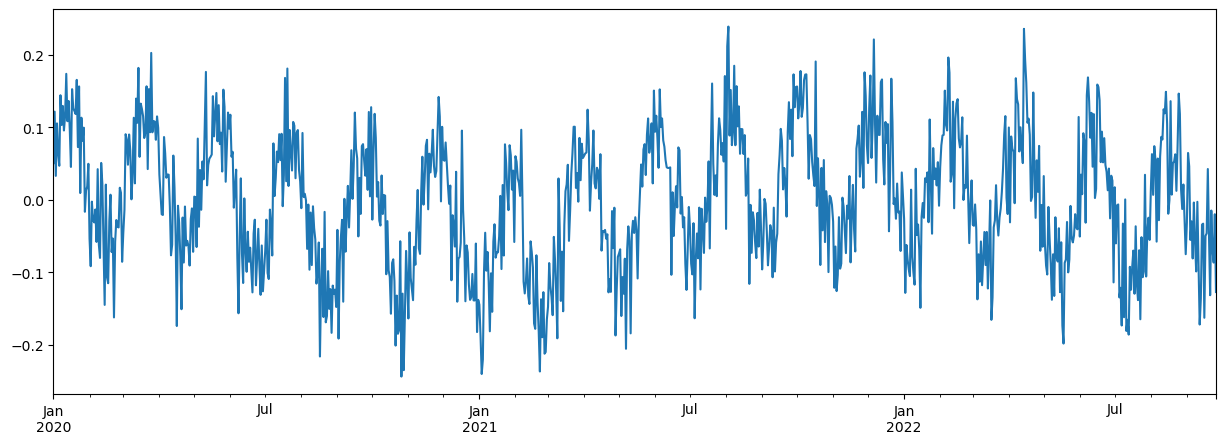

In [160]:
detrended_series_without_seasonal = detrended_series - predicted_seasonal_series
detrended_series_without_seasonal.plot(figsize=(15, 5))

In [161]:
from sklearn.metrics import explained_variance_score
# Decycle the time series via fourier transform

errors = {}
cycles = []
last_cycle = np.zeros(1000)
series_to_be_fit = detrended_series_without_seasonal

for j in range(10):
    series_to_be_fit = series_to_be_fit - last_cycle
    errors = {}
    base_cycles = {}
    all_predicted_series = {}
    max_variance = 0
    max_variance_index = 0
    for i in range(1, 250):
        s = np.sin(2 * np.pi * line / i)
        s2 = np.cos(2 * np.pi * line / i)
        serie_sin = pd.Series(s, index=time_index, name='sin_cycle_value'+str(i))
        serie_cos = pd.Series(s2, index=time_index, name='cos_cycle_value'+str(i))
        X = pd.concat([serie_sin, serie_cos], axis=1)

        model = LinearRegression()
        model.fit(X, series_to_be_fit)
        predicted_cycle = model.predict(X)

        predicted_cycle_series = pd.Series(predicted_cycle, index=time_index, name='predicted_cycle_'+str(i))
        all_predicted_series[i] = predicted_cycle_series
        base_cycles[i] = serie

        error = explained_variance_score(series_to_be_fit, predicted_cycle_series)
        if max_variance < error:
            max_variance = error
            max_variance_index = i
        errors[i] = error

    last_cycle = all_predicted_series[max_variance_index]
    cycles.append(last_cycle)
    print('Max variance: ', max_variance, 'Index: ', max_variance_index)

Max variance:  0.10421694506492918 Index:  70
Max variance:  0.05966319359266459 Index:  6
Max variance:  0.054693417679630096 Index:  7
Max variance:  0.015463684063313221 Index:  8
Max variance:  0.008498077523368619 Index:  16
Max variance:  0.007890502568596025 Index:  9
Max variance:  0.008985051807231081 Index:  12
Max variance:  0.008548226295825745 Index:  30
Max variance:  0.007718153089285695 Index:  11
Max variance:  0.003812985788986034 Index:  19


In [163]:
cycles_df = pd.concat(cycles, axis=1)
cycles_df

,predicted_cycle_70,predicted_cycle_6,predicted_cycle_7,predicted_cycle_8,predicted_cycle_16,predicted_cycle_9,predicted_cycle_12,predicted_cycle_30,predicted_cycle_11,predicted_cycle_19
2020-01-01,0.038511,-0.020538,0.024911,0.012480,0.009988,0.008834,0.009187,0.009927,0.007085,0.002243
2020-01-02,0.038512,-0.022620,0.023772,0.012946,0.009880,0.008493,0.008884,0.009865,0.006690,0.002024
2020-01-03,0.038509,-0.024452,0.022441,0.013331,0.009756,0.008109,0.008556,0.009800,0.006272,0.001804
2020-01-04,0.038503,-0.026015,0.020927,0.013633,0.009616,0.007685,0.008204,0.009730,0.005834,0.001581
2020-01-05,0.038493,-0.027290,0.019243,0.013849,0.009462,0.007224,0.007830,0.009655,0.005377,0.001357
...,...,...,...,...,...,...,...,...,...,...
2022-09-22,-0.041072,0.029174,-0.008214,-0.010197,-0.001132,0.006202,-0.008110,-0.007083,0.004415,-0.006312
2022-09-23,-0.041249,0.029521,-0.010546,-0.010954,-0.001543,0.005641,-0.008466,-0.007249,0.003909,-0.006388
2022-09-24,-0.041424,0.029546,-0.012795,-0.011644,-0.001951,0.005053,-0.008799,-0.007412,0.003390,-0.006457
2022-09-25,-0.041596,0.029247,-0.014941,-0.012263,-0.002357,0.004439,-0.009108,-0.007572,0.002860,-0.006519


<AxesSubplot:>

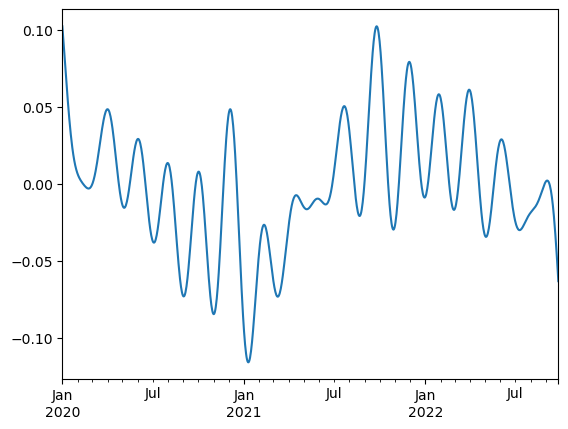

In [164]:
cycles_df.sum(axis=1).plot()

<AxesSubplot:>

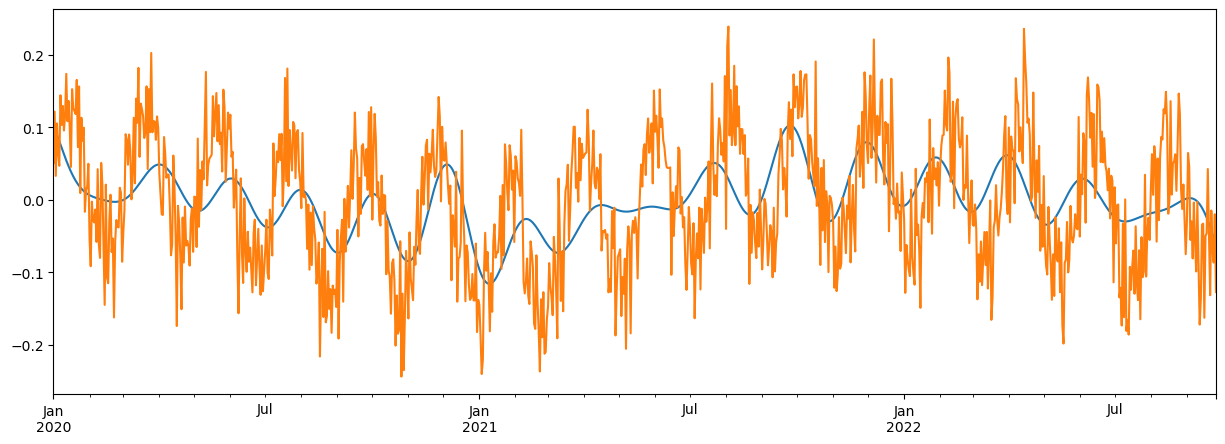

In [165]:
cycle_effects_series = cycles_df.sum(axis=1)
cycle_effects_series = pd.Series(cycle_effects_series, index=time_index)

cleaned_series = detrended_series_without_seasonal - cycle_effects_series

cycle_effects_series.plot(figsize=(15, 5))
detrended_series_without_seasonal.plot(figsize=(15, 5))

<AxesSubplot:>

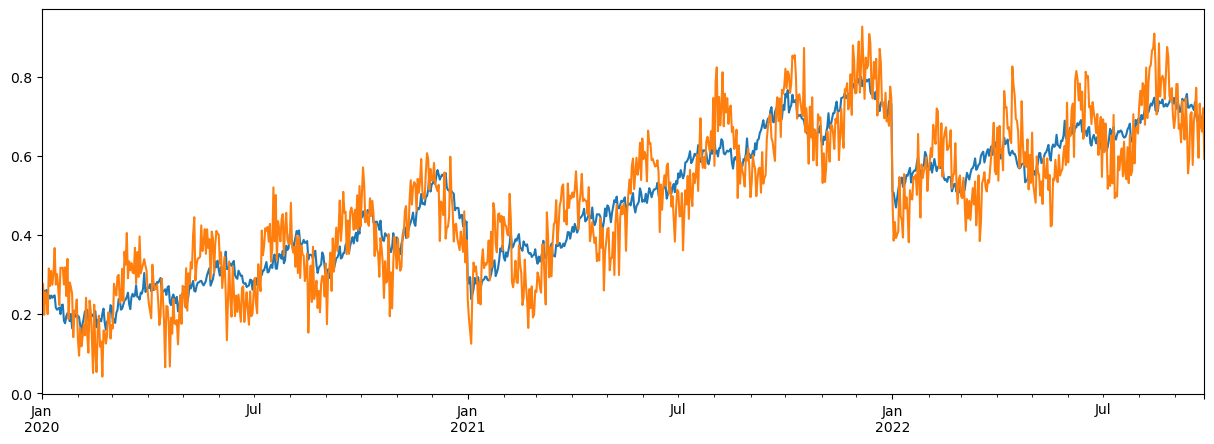

In [166]:
full_series = cycle_effects_series + predicted_seasonal_series + predicted_trend_series
full_series.plot(figsize=(15, 5))
series_to_be_predicted.plot(figsize=(15, 5))

In [167]:
std = series_to_be_predicted.std()
std_no_trend = series_to_be_predicted_without_trend.std()

mse_final = mean_squared_error(series_to_be_predicted, full_series)
mse_expected = mean_squared_error(series_to_be_predicted, series_to_be_predicted_without_noise)
print('MSE final: ', mse_final, 'MSE expected: ', mse_expected)
print('STD', std, 'STD without trend', std_no_trend)


MSE final:  0.0061221827564627365 MSE expected:  0.0025665233379625106
STD 0.185361392783364 STD without trend 0.11145066999306165
